In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime, timedelta

# Indicator Creation

In this notebook we will create new interesting features which we believe to be relevant for clustering purposes. The indicators we will try to create in this notebook are:
1. Account age in days (From account creation till the release of this dataset) (datetime(2022,9,29,11,0,0)) √
2. Account tweets number √
3. Account highest daily tweet count √
4. Account average tweet count √
5. Account tweet number over periods of time (e.g. Covid-19) √ (Partially, we can make other days like the day elon declared he wants to buy twitter)
6. Account tweet hashtag average √
7. Account average tweet text length √
8. Account average number of mentions per tweet √
9. Special Characters √
    1. Tweet number of special characters √
    2. Account average number of special characters in tweets √
10. Account's Entropy
11. Account Number of likes √
12. Account Average of likes √
13. Account Number of comments √
14. Account Average of comments √
15. Account discussion creation score (Tweet to retweet ratio) √
16. Ratio between number of tweets and number of likes √
17. Ratio between number of tweets and number of comments √

In [2]:
users_df = pd.read_csv("dataset/users_dataset_cleaned.csv")
tweets_df = pd.read_csv("dataset/tweets_dataset_cleaned.csv")
#merged_df = pd.read_csv("dataset/tweets_dataset_cleaned.csv")
#merged_df = pd.read_csv("dataset/merged_dataset_cleaned.csv", lineterminator="\n")


"""
if merged_df.columns[-1] == str("text\r"):
    merged_df = pd.read_csv("dataset/tweets_dataset_cleaned.csv")
"""
#merged_df.info(verbose=True)
#merged_df.head()


'\nif merged_df.columns[-1] == str("text\r"):\n    merged_df = pd.read_csv("dataset/tweets_dataset_cleaned.csv")\n'

In [3]:
merged_df = pd.merge(users_df, tweets_df, on="user_id")

merged_df.rename(columns={"created_at_x" : "account_created"}, inplace=True)
merged_df.rename(columns={"created_at_y" : "tweet_created"}, inplace=True)
rows_to_delete = merged_df[merged_df["account_created"] > merged_df["tweet_created"]].index
merged_df.drop(rows_to_delete, inplace=True)

merged_df.info(verbose=True)
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460637 entries, 0 to 10460636
Data columns (total 15 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int64 
 1   name             object
 2   lang             object
 3   bot              int64 
 4   account_created  object
 5   statuses_count   int64 
 6   tweet_id         int64 
 7   retweet_count    int64 
 8   reply_count      int64 
 9   favorite_count   int64 
 10  num_hashtags     int64 
 11  num_urls         int64 
 12  num_mentions     int64 
 13  tweet_created    object
 14  text             object
dtypes: int64(10), object(5)
memory usage: 1.2+ GB


,user_id,name,lang,bot,account_created,statuses_count,tweet_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created,text
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,486718663223828480,0,0,0,0,0,1,2019-07-11 03:49:06,"@4fri2endly0 ""A business that makes nothing bu..."
1,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,479535357126393856,0,0,0,0,0,0,2019-06-21 08:05:13,"""Happiness is not a station you arrive at, but..."
2,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,451700895491706880,0,0,0,0,0,0,2019-04-05 12:41:00,Music flow.
3,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,491920040405397504,0,0,0,0,0,1,2019-07-25 12:17:31,@_SimplyKC follow meeee...
4,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,460522543628046336,0,0,0,0,0,0,2019-04-29 20:55:05,"""You are the only person on earth who can use ..."


## 1. Account age in days
Creating the account age in days feature and adding it to the dataframe.

In [4]:
users_df["created_at"] = pd.to_datetime(users_df["created_at"], errors="coerce") # Even though this is already done in the previous notebook, this information is turned to string when converting the merged_df to csv
release_of_dataset = datetime(2022,9,29,11,0,0)
users_df["account_age_in_days"] = (release_of_dataset - users_df['created_at']).dt.days

users_df.head()

# Keeping info in merged_df too for further calculations
merged_df["account_created"] = pd.to_datetime(merged_df["account_created"], errors="coerce")
merged_df["account_age_in_days"] = (release_of_dataset - merged_df['account_created']).dt.days

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198


# 2. Account number of tweets

Creating the account number of tweets.

In [5]:
#users_df = users_df.merge(merged_df.groupby('user_id').size().reset_index(name='counts'), how="left")
users_df = users_df.merge(merged_df.groupby('user_id', as_index=False).size(), on="user_id", how="left")
users_df.rename(columns={"size": "number_of_tweets"}, inplace=True)
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434
...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99


# 4. Account average tweets per day

Creating the account average tweets per day and adding it to the dataframe.

In [6]:
merged_df["account_average_tweets_per_day"] = merged_df["statuses_count"]/merged_df["account_age_in_days"]

merged_df.head()

,user_id,name,lang,bot,account_created,statuses_count,tweet_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created,text,account_age_in_days,account_average_tweets_per_day
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,486718663223828480,0,0,0,0,0,1,2019-07-11 03:49:06,"@4fri2endly0 ""A business that makes nothing bu...",1314,0.057839
1,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,479535357126393856,0,0,0,0,0,0,2019-06-21 08:05:13,"""Happiness is not a station you arrive at, but...",1314,0.057839
2,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,451700895491706880,0,0,0,0,0,0,2019-04-05 12:41:00,Music flow.,1314,0.057839
3,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,491920040405397504,0,0,0,0,0,1,2019-07-25 12:17:31,@_SimplyKC follow meeee...,1314,0.057839
4,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,460522543628046336,0,0,0,0,0,0,2019-04-29 20:55:05,"""You are the only person on earth who can use ...",1314,0.057839


Idea, isn't better to add this attribute to the users_df ? Because it's a user caractherization, and having it in the merged_df is gonna be redundant

In [7]:
users_df["account_average_tweets_per_day"] = users_df["statuses_count"]/users_df["account_age_in_days"]
users_df.head()

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023


We need to know the tweet age in days, the average number of tweets between the days that the user used twitter

In [8]:
# Creating the tweet age in days (for each) till the release of dataset
merged_df["tweet_created"] = pd.to_datetime(merged_df["tweet_created"], errors="coerce")
#merged_df['tweet_created'] = merged_df['tweet_created'].apply(pd.to_datetime)
release_of_dataset = datetime(2022,9,29,11,0,0)

merged_df['tweet_created_just_days'] = merged_df['tweet_created'].dt.date
merged_df["tweet_created_just_days"] = pd.to_datetime(merged_df["tweet_created_just_days"], errors="coerce")
merged_df['tweet_age_in_days'] = (release_of_dataset - merged_df['tweet_created_just_days']).dt.days

merged_df.drop(columns="tweet_created_just_days", inplace=True)
merged_df.head()

,user_id,name,lang,bot,account_created,statuses_count,tweet_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created,text,account_age_in_days,account_average_tweets_per_day,tweet_age_in_days
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,486718663223828480,0,0,0,0,0,1,2019-07-11 03:49:06,"@4fri2endly0 ""A business that makes nothing bu...",1314,0.057839,1176
1,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,479535357126393856,0,0,0,0,0,0,2019-06-21 08:05:13,"""Happiness is not a station you arrive at, but...",1314,0.057839,1196
2,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,451700895491706880,0,0,0,0,0,0,2019-04-05 12:41:00,Music flow.,1314,0.057839,1273
3,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,491920040405397504,0,0,0,0,0,1,2019-07-25 12:17:31,@_SimplyKC follow meeee...,1314,0.057839,1162
4,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,460522543628046336,0,0,0,0,0,0,2019-04-29 20:55:05,"""You are the only person on earth who can use ...",1314,0.057839,1249


Adding indicator for average number of tweets per day in which the account ACTUALLY tweeted - Gianluca 

In [9]:
tmp = merged_df.groupby(["user_id", "tweet_age_in_days"], as_index=False).size()

# computing average
tmp = tmp.groupby(["user_id"], as_index=False).mean()
tmp=pd.DataFrame(tmp[["user_id", "size"]])
avg_df = tmp.rename(columns={"size": "avg_tweets_per_actual_day"})# Should we rename this to "avg_tweets_per_active_day"? Or "avg_num_of_tweets_when_active"? -Tengel
users_df = users_df.merge(avg_df, on="user_id", how="left")
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165
...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348


## 3. Account highest daily tweet count

Creating the account highest daily tweet count and adding it too the dataframe.

In [10]:

# Trying to see how the group by num of days works
tmp = merged_df.groupby(["user_id", "tweet_age_in_days"], as_index=False).size()

# computing average
tmp = tmp.iloc[tmp.groupby("user_id")["size"].idxmax()]
tmp = tmp.rename(columns={"size": "max_number_of_tweet_in_a_day", "tweet_age_in_days": "day_with_most_tweets"}) # Is day with most tweets the day where the high score was made? - Tengel

users_df = users_df.merge(tmp, on="user_id", how="left")
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50
...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12


In [11]:
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50
...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12


## 5. Tweet num over period of time

Creating the account tweet num by period of time

In [12]:
covid19_start = release_of_dataset - datetime(2020, 3, 11)
covid19_ipotetic_end_of_restrictions = release_of_dataset - datetime(2021, 12, 15)
covid19_start = covid19_start.days
covid19_ipotetic_end_of_restrictions = covid19_ipotetic_end_of_restrictions.days
temp = merged_df[merged_df["tweet_age_in_days"]<=covid19_start]
temp = temp[temp["tweet_age_in_days"]>covid19_ipotetic_end_of_restrictions]
temp = temp.groupby("user_id", as_index=False).size()
temp = temp.rename(columns={"size": "covid19_num_of_tweets"})
users_df = users_df.merge(temp, on="user_id", how='left')
users_df["covid19_num_of_tweets"].replace(np.nan, 0, inplace=True)
users_df


,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0


COVID 19 from 11/03/2020 to 15/12/2021 (pretty much the period of time in which we had restictions and had to stay home) # Should add a citation here - Tengel

## 6. Average of hashtags per user

Creating the account average of hashtags in tweets

In [13]:
# Trying to see how the group by num of days works
tmp = merged_df[["user_id", "num_hashtags"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"num_hashtags": "avg_hashtags"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101


## 7. Average tweet text length per user

Creating the account average tweet length

In [14]:
merged_df["text_length"] = merged_df["text"].str.len() 
tmp = merged_df[["user_id", "text_length"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"text_length": "avg_text_length"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081


## 8. Average of mentions per user

Creating the account average of hashtags in tweets

In [15]:
# Trying to see how the group by num of days works
tmp = merged_df[["user_id", "num_mentions"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"num_mentions": "avg_mentions"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048,0.285714
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379,0.344828
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862,0.006627
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045,0.526209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326,0.776403
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392,0.542785
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667,0.333333
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081,0.383838


## 9. Average num of special characters in text per user and num of special characters per tweet

Creating the account average of special characters in tweets

In [16]:
merged_df["special_char_in_text"] = merged_df["text"].str.len() - merged_df["text"].str.findall('[\w]').str.len()
tmp = merged_df[["user_id", "special_char_in_text"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"special_char_in_text": "avg_special_char_in_text"})
users_df = users_df.merge(tmp, on="user_id", how='left')
merged_df
users_df

,user_id,name,lang,bot,account_created,statuses_count,tweet_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created,text,account_age_in_days,account_average_tweets_per_day,tweet_age_in_days,text_length,special_char_in_text
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,486718663223828480,0,0,0,0,0,1,2019-07-11 03:49:06,"@4fri2endly0 ""A business that makes nothing bu...",1314,0.057839,1176,87,19
1,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,479535357126393856,0,0,0,0,0,0,2019-06-21 08:05:13,"""Happiness is not a station you arrive at, but...",1314,0.057839,1196,93,22
2,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,451700895491706880,0,0,0,0,0,0,2019-04-05 12:41:00,Music flow.,1314,0.057839,1273,11,2
3,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,491920040405397504,0,0,0,0,0,1,2019-07-25 12:17:31,@_SimplyKC follow meeee...,1314,0.057839,1162,26,6
4,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,460522543628046336,0,0,0,0,0,0,2019-04-29 20:55:05,"""You are the only person on earth who can use ...",1314,0.057839,1249,73,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10460632,933183398,Corvanna,en,0,2017-11-09 23:24:16,5279,591409992605028352,1,0,0,0,0,1,2020-04-25 01:15:04,RT @_MarcussA: Phone dry,1784,2.959081,887,25,6
10460633,933183398,Corvanna,en,0,2017-11-09 23:24:16,5279,570728918614974464,0,0,0,0,0,0,2020-02-27 23:35:52,@_Freak_x1,1784,2.959081,945,11,2
10460634,933183398,Corvanna,en,0,2017-11-09 23:24:16,5279,582259121648320512,1,0,0,0,0,0,2020-03-30 19:12:47,Something wrong,1784,2.959081,913,16,2
10460635,933183398,Corvanna,en,0,2017-11-09 23:24:16,5279,591238256626380800,0,0,0,0,0,0,2020-04-24 13:52:39,always going over my data,1784,2.959081,888,26,5


,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048,0.285714,14.563492
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379,0.344828,15.336207
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000,0.000000,5.250000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862,0.006627,19.241532
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045,0.526209,15.024461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326,0.776403,13.198858
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392,0.542785,13.324051
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667,0.333333,15.833333
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081,0.383838,14.343434


## 11. Number of likes per user

Creating the account number of likes in tweets

In [17]:
# Trying to see how the group by num of days works
tmp = merged_df[["user_id", "favorite_count"]].groupby(["user_id"], as_index=False).sum()
tmp = tmp.rename(columns={"favorite_count": "total_likes"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048,0.285714,14.563492,5
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379,0.344828,15.336207,6
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000,0.000000,5.250000,0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862,0.006627,19.241532,252
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045,0.526209,15.024461,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326,0.776403,13.198858,60
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392,0.542785,13.324051,432
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667,0.333333,15.833333,0
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081,0.383838,14.343434,9


## 12. Average of likes per user

Creating the account average of likes in tweets

In [18]:
# Trying to see how the group by num of days works
tmp = merged_df[["user_id", "favorite_count"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"favorite_count": "avt_favorite_count"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048,0.285714,14.563492,5,0.039683
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379,0.344828,15.336207,6,0.051724
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000,0.000000,5.250000,0,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862,0.006627,19.241532,252,0.185567
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045,0.526209,15.024461,213,0.062027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326,0.776403,13.198858,60,0.057088
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392,0.542785,13.324051,432,0.218734
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667,0.333333,15.833333,0,0.000000
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081,0.383838,14.343434,9,0.090909


## 13. Number of comments per user

Creating the account number of comments in tweets

In [19]:
# Trying to see how the group by num of days works
tmp = merged_df[["user_id", "reply_count"]].groupby(["user_id"], as_index=False).sum()
tmp = tmp.rename(columns={"reply_count": "total_replies"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,day_with_most_tweets,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,1250,18,0.0,0.103175,64.619048,0.285714,14.563492,5,0.039683,0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,1250,17,0.0,0.025862,70.491379,0.344828,15.336207,6,0.051724,0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,2302,3,0.0,0.000000,19.250000,0.000000,5.250000,0,0.000000,0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,1063,143,0.0,0.081738,89.385862,0.006627,19.241532,252,0.185567,0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,951,50,1453.0,0.128713,74.419045,0.526209,15.024461,213,0.062027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,979,52,316.0,0.214082,54.307326,0.776403,13.198858,60,0.057088,0
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,1581,90,215.0,0.126582,61.231392,0.542785,13.324051,432,0.218734,0
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,1883,2,0.0,0.333333,67.666667,0.333333,15.833333,0,0.000000,0
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,1250,12,0.0,0.010101,64.808081,0.383838,14.343434,9,0.090909,0


## 14. Average of comments per user

Creating the account average of comments in tweets

In [20]:
tmp = merged_df[["user_id", "reply_count"]].groupby(["user_id"], as_index=False).mean()
tmp = tmp.rename(columns={"reply_count": "avt_reply_count"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,...,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,...,18,0.0,0.103175,64.619048,0.285714,14.563492,5,0.039683,0,0.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,...,17,0.0,0.025862,70.491379,0.344828,15.336207,6,0.051724,0,0.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,...,3,0.0,0.000000,19.250000,0.000000,5.250000,0,0.000000,0,0.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,...,143,0.0,0.081738,89.385862,0.006627,19.241532,252,0.185567,0,0.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,...,50,1453.0,0.128713,74.419045,0.526209,15.024461,213,0.062027,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,...,52,316.0,0.214082,54.307326,0.776403,13.198858,60,0.057088,0,0.0
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,...,90,215.0,0.126582,61.231392,0.542785,13.324051,432,0.218734,0,0.0
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,...,2,0.0,0.333333,67.666667,0.333333,15.833333,0,0.000000,0,0.0
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,...,12,0.0,0.010101,64.808081,0.383838,14.343434,9,0.090909,0,0.0


## 15. Account discussion creation score
Creating the account tweet to retweet ratio

In [21]:
tmp = merged_df[["user_id", "retweet_count"]].groupby(["user_id"], as_index=False).sum()
tmp = tmp.rename(columns={"retweet_count": "total_retweet_count"})
users_df = users_df.merge(tmp, on="user_id", how='left')
users_df["total_retweet_count"].replace(np.nan, 0, inplace=True)
users_df["account_discussion_creation_ratio"] = users_df["number_of_tweets"]/users_df["total_retweet_count"]
users_df['account_discussion_creation_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,...,avg_hashtags,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,...,0.103175,64.619048,0.285714,14.563492,5,0.039683,0,0.0,5,25.200000
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,...,0.025862,70.491379,0.344828,15.336207,6,0.051724,0,0.0,3,38.666667
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,...,0.000000,19.250000,0.000000,5.250000,0,0.000000,0,0.0,0,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,...,0.081738,89.385862,0.006627,19.241532,252,0.185567,0,0.0,1187,1.144061
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,...,0.128713,74.419045,0.526209,15.024461,213,0.062027,0,0.0,60,57.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,...,0.214082,54.307326,0.776403,13.198858,60,0.057088,0,0.0,6350333,0.000166
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,...,0.126582,61.231392,0.542785,13.324051,432,0.218734,0,0.0,775759,0.002546
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,...,0.333333,67.666667,0.333333,15.833333,0,0.000000,0,0.0,0,0.000000
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,...,0.010101,64.808081,0.383838,14.343434,9,0.090909,0,0.0,7,14.142857


## 16. Ratio between num of tweets and num of likes

Creating the account ratio between num of tweets and num of likes

In [22]:
users_df["tweet_num_likes_ratio"] = users_df["number_of_tweets"]/users_df["total_likes"]
users_df['tweet_num_likes_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,...,avg_text_length,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,...,64.619048,0.285714,14.563492,5,0.039683,0,0.0,5,25.200000,25.200000
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,...,70.491379,0.344828,15.336207,6,0.051724,0,0.0,3,38.666667,19.333333
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,...,19.250000,0.000000,5.250000,0,0.000000,0,0.0,0,0.000000,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,...,89.385862,0.006627,19.241532,252,0.185567,0,0.0,1187,1.144061,5.388889
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,...,74.419045,0.526209,15.024461,213,0.062027,0,0.0,60,57.233333,16.122066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,...,54.307326,0.776403,13.198858,60,0.057088,0,0.0,6350333,0.000166,17.516667
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,...,61.231392,0.542785,13.324051,432,0.218734,0,0.0,775759,0.002546,4.571759
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,...,67.666667,0.333333,15.833333,0,0.000000,0,0.0,0,0.000000,0.000000
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,...,64.808081,0.383838,14.343434,9,0.090909,0,0.0,7,14.142857,11.000000


## 17. Ratio between num of tweets and num of comments

Creating the account ratio between num of tweets and num of comments

In [23]:
users_df["tweet_num_replies_ratio"] = users_df["number_of_tweets"]/users_df["total_replies"] 
users_df['tweet_num_replies_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
users_df

,user_id,name,lang,bot,created_at,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,...,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,1314,126,0.057839,4.666667,...,0.285714,14.563492,5,0.039683,0,0.0,5,25.200000,25.200000,0.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,1311,116,0.041190,4.640000,...,0.344828,15.336207,6,0.051724,0,0.0,3,38.666667,19.333333,0.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3,2709,4,0.001107,2.000000,...,0.000000,5.250000,0,0.000000,0,0.0,0,0.000000,0.000000,0.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,2080,1358,0.024038,8.035503,...,0.006627,19.241532,252,0.185567,0,0.0,1187,1.144061,5.388889,0.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,1198,3434,5.914023,28.380165,...,0.526209,15.024461,213,0.062027,0,0.0,60,57.233333,16.122066,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11104,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126,1034,1051,1.088975,11.677778,...,0.776403,13.198858,60,0.057088,0,0.0,6350333,0.000166,17.516667,0.0
11105,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024,1616,1975,1.871287,7.397004,...,0.542785,13.324051,432,0.218734,0,0.0,775759,0.002546,4.571759,0.0
11106,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6,2740,6,0.002190,1.500000,...,0.333333,15.833333,0,0.000000,0,0.0,0,0.000000,0.000000,0.0
11107,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42,1296,99,0.032407,4.304348,...,0.383838,14.343434,9,0.090909,0,0.0,7,14.142857,11.000000,0.0


## Cast to integers the values of the indicators for Users_df

In [24]:
users_df['account_average_tweets_per_day'] = pd.to_numeric(users_df['account_average_tweets_per_day'], errors='coerce').astype(np.int64)
users_df['avg_tweets_per_actual_day'] = pd.to_numeric(users_df['avg_tweets_per_actual_day'], errors='coerce').astype(np.int64)
users_df['covid19_num_of_tweets'] = pd.to_numeric(users_df['covid19_num_of_tweets'], errors='coerce').astype(np.int64)
users_df['avg_hashtags'] = pd.to_numeric(users_df['avg_hashtags'], errors='coerce').astype(np.int64)
users_df['avg_text_length'] = pd.to_numeric(users_df['avg_text_length'], errors='coerce').astype(np.int64)
users_df['avg_mentions'] = pd.to_numeric(users_df['avg_mentions'], errors='coerce').astype(np.int64)
users_df['avg_special_char_in_text'] = pd.to_numeric(users_df['avg_special_char_in_text'], errors='coerce').astype(np.int64)
users_df['avt_favorite_count'] = pd.to_numeric(users_df['avt_favorite_count'], errors='coerce').astype(np.int64)
users_df['total_replies'] = pd.to_numeric(users_df['total_replies'], errors='coerce').astype(np.int64)
users_df['avt_reply_count'] = pd.to_numeric(users_df['avt_reply_count'], errors='coerce').astype(np.int64)
users_df['total_retweet_count'] = pd.to_numeric(users_df['total_retweet_count'], errors='coerce').astype(np.int64)
users_df['account_discussion_creation_ratio'] = pd.to_numeric(users_df['account_discussion_creation_ratio'], errors='coerce').astype(np.int64)
users_df['tweet_num_likes_ratio'] = pd.to_numeric(users_df['tweet_num_likes_ratio'], errors='coerce').astype(np.int64)
users_df['tweet_num_replies_ratio'] = pd.to_numeric(users_df['tweet_num_replies_ratio'], errors='coerce').astype(np.int64)

# Change Day with most tweet from num of days to actual day
users_df['day_with_most_tweets'] = datetime(2022,9,29) -  users_df['day_with_most_tweets'].apply(timedelta)

users_df.info(verbose=True, show_counts=True)
users_df.to_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv",index=False) # Removes the counting of the Index rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11108
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   user_id                            11109 non-null  int64         
 1   name                               11108 non-null  object        
 2   lang                               11109 non-null  object        
 3   bot                                11109 non-null  int64         
 4   created_at                         11109 non-null  datetime64[ns]
 5   statuses_count                     11109 non-null  int64         
 6   account_age_in_days                11109 non-null  int64         
 7   number_of_tweets                   11109 non-null  int64         
 8   account_average_tweets_per_day     11109 non-null  int64         
 9   avg_tweets_per_actual_day          11109 non-null  int64         
 10  day_with_most_tweets              

<AxesSubplot: >

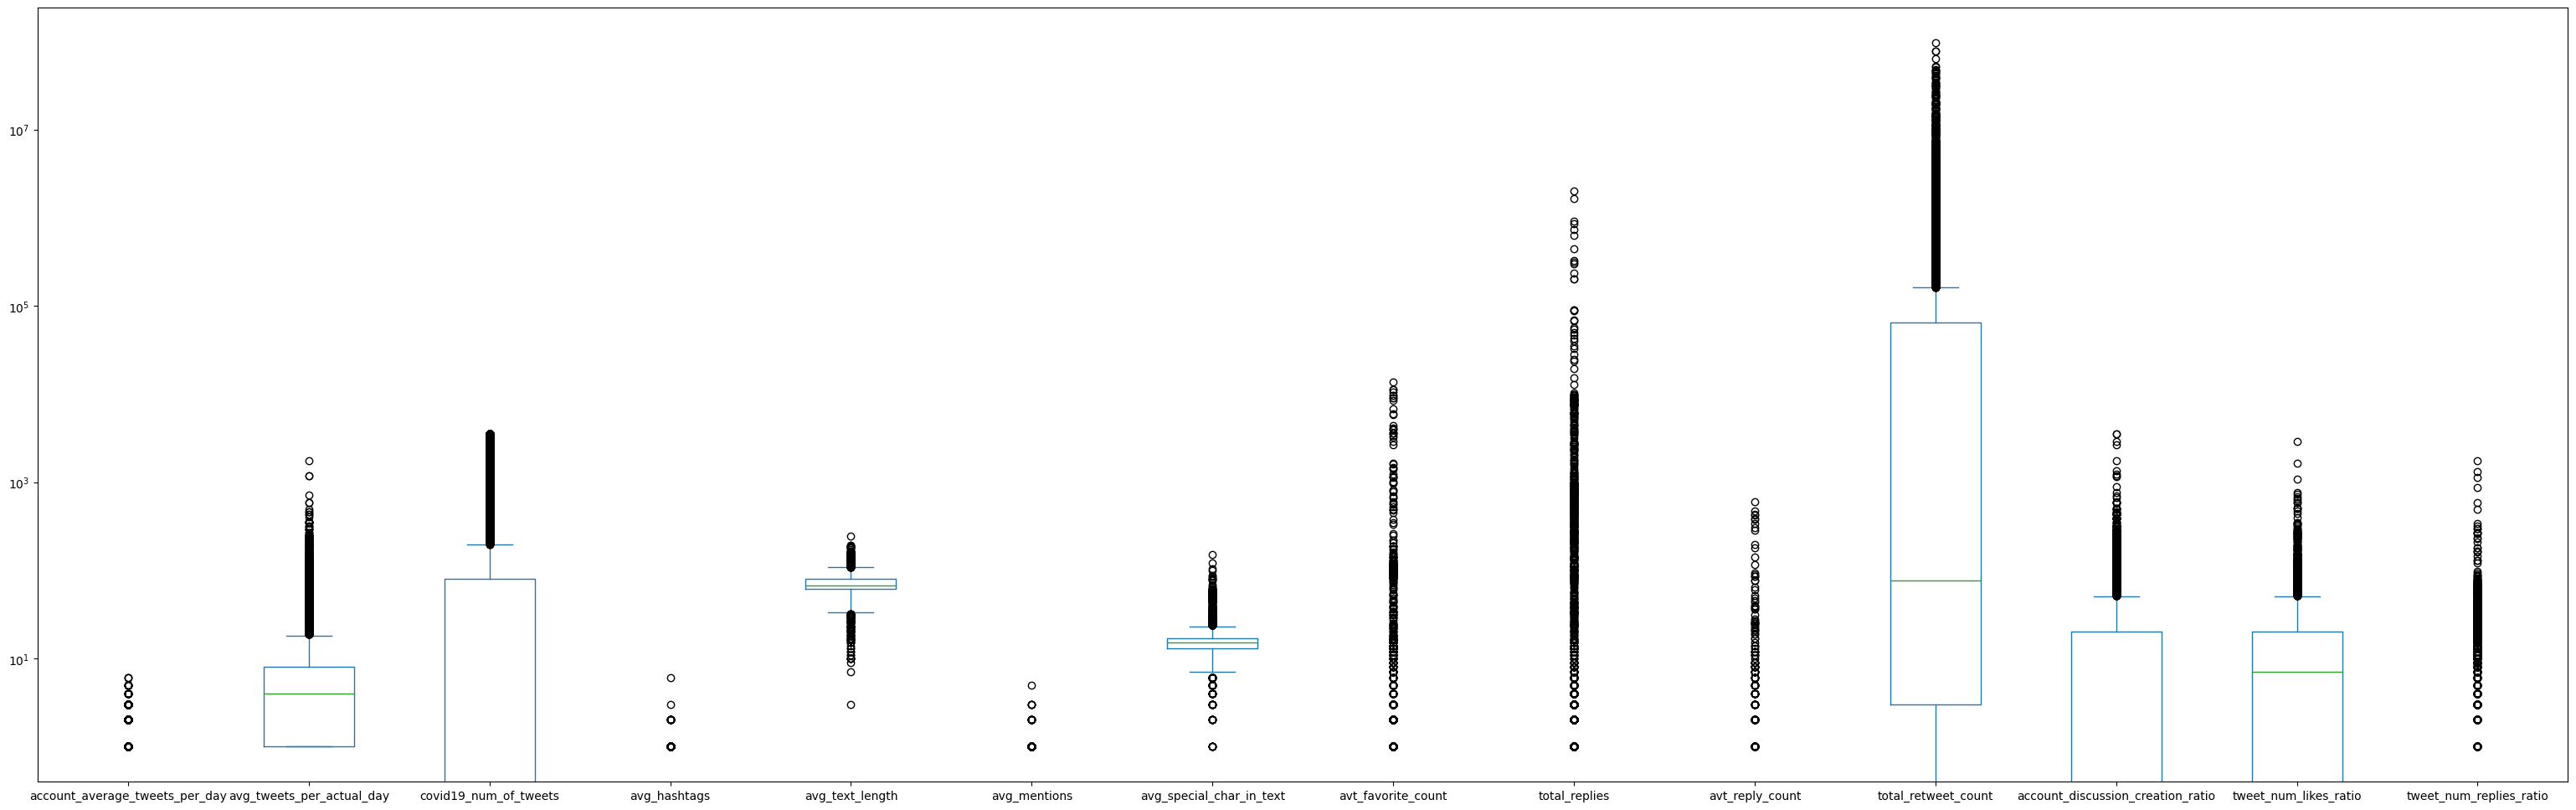

In [25]:
indicator_columns_users = ['account_average_tweets_per_day', 'avg_tweets_per_actual_day', 'covid19_num_of_tweets', 'avg_hashtags', 
                            'avg_text_length', 'avg_mentions', 'avg_special_char_in_text', 'avt_favorite_count', 'total_replies',
                            'avt_reply_count', 'total_retweet_count', 'account_discussion_creation_ratio', 'tweet_num_likes_ratio',
                            'tweet_num_replies_ratio']

users_df[indicator_columns_users].plot(kind='box', figsize=(39,12), logy=True)


users_df_desc = users_df[indicator_columns_users].describe()
users_df_desc.to_csv('./dataset/users_df_describe_indicators.csv')

## Export merged_df with indicators

In [26]:
merged_df.to_csv("./dataset/merged_df_dataset_cleaned_with_indicators.csv",index=False)

## Create a csv with number describing merged_df

In [27]:
merged_df_desc = merged_df.describe()
merged_df_desc.drop(columns="user_id",inplace=True)
merged_df_desc.drop(columns="tweet_id",inplace=True)
merged_df_desc.drop(columns="bot",inplace=True)
merged_df_desc.to_csv('./dataset/merged_df_describe_indicators.csv')

<AxesSubplot: >

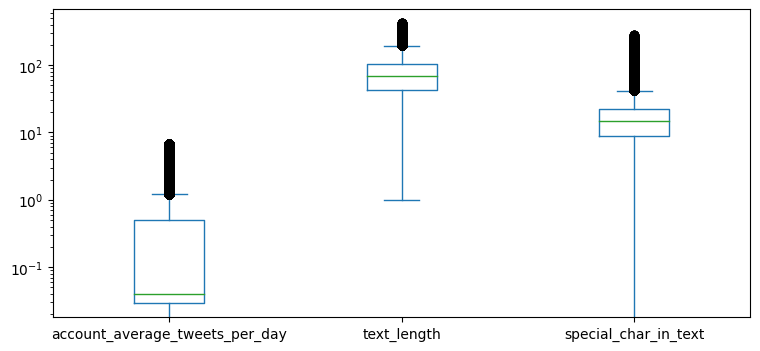

In [28]:
merged_df_only_indicators = merged_df[['account_average_tweets_per_day', 'text_length', 'special_char_in_text']]
merged_df_only_indicators.plot(kind='box', figsize=(9,4), logy=True)